In [2]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
C = torch.randn((27, 2))

In [10]:
C[5]

tensor([1.1019, 0.0295])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
h = torch.tanh((emb.view(-1, 6) @ W1) + b1)

In [14]:
h

tensor([[-0.8088, -0.7317,  0.9994,  ..., -0.0728, -0.7763, -0.7423],
        [ 0.7550, -0.6624,  0.9996,  ...,  0.9845, -0.9606, -0.9514],
        [ 0.9995, -0.9855,  0.8214,  ..., -0.9999, -0.4800,  0.7024],
        ...,
        [ 0.9918,  0.3637,  0.8172,  ...,  0.9955,  0.9915,  0.8999],
        [ 0.9907, -0.6720,  0.0208,  ..., -0.9906,  0.9833,  0.9893],
        [ 0.9929, -0.3986,  0.9097,  ..., -0.8042,  0.9118,  0.4004]])

In [15]:
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = (h @ W2) + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [20]:
prob.shape

torch.Size([228146, 27])

In [21]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()

In [22]:
loss

tensor(17.0078)

In [49]:
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, W2, b1, b2]

In [50]:
sum(p.nelement() for p in parameters)

11897

In [51]:
for p in parameters:
    p.requires_grad = True


In [52]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [53]:
lri = []
lossi = []
stepi = []

In [68]:
for i in range(200000):
    # making batches
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


1.7533679008483887


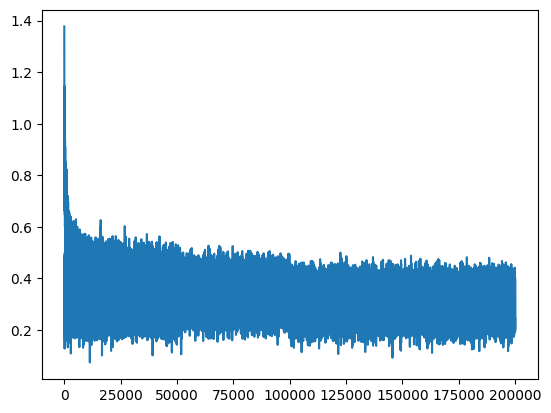

In [69]:
plt.plot(stepi, lossi)

In [70]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0758, grad_fn=<NllLossBackward0>)

In [71]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1319, grad_fn=<NllLossBackward0>)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [75]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True)
        context = context[1:] + [ix]
        out.append(itos[ix.item()])
        if ix == 0:
            print(''.join(out))
            out = []
            break 

saddy.
grohanee.
edrykeisaell.
mikka.
caster.
virlatoriaan.
lusteferick.
yan.
pri.
junathruz.
baylyn.
ngreen.
nehia.
abdullie.
keylandinx.
havodse.
esimrie.
yuvi.
tyshonn.
kylen.
